In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

Set the result of classification we want and read it to `X`

In [111]:
classification = "RF"

In [112]:
df = pd.read_csv(rf'D:\Github\Data_Mining_113-2\Data_Mining_Final\classification\result\{classification}_unknown.csv')
X_ids = df.iloc[:, 0]
X = df.iloc[:, 1:]
X = X.to_numpy()

Calculate the distance

In [113]:
n= X.shape[0]
dis = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        dis[i, j] = np.linalg.norm(X[i] - X[j])
dis

array([[  0.        , 301.6238201 , 302.22514096, ..., 298.13635932,
        264.52411947, 277.20659429],
       [301.6238201 ,   0.        , 276.31967282, ..., 271.05446836,
        279.84020002, 261.74500823],
       [302.22514096, 276.31967282,   0.        , ..., 314.3891695 ,
        291.23503362, 272.44274638],
       ...,
       [298.13635932, 271.05446836, 314.3891695 , ...,   0.        ,
        278.13177452, 268.46775511],
       [264.52411947, 279.84020002, 291.23503362, ..., 278.13177452,
          0.        , 186.17261683],
       [277.20659429, 261.74500823, 272.44274638, ..., 268.46775511,
        186.17261683,   0.        ]], shape=(219, 219))

Set the Similarity matrix with k-Nearest Neighbors (k-NN) Graph

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.66434916]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


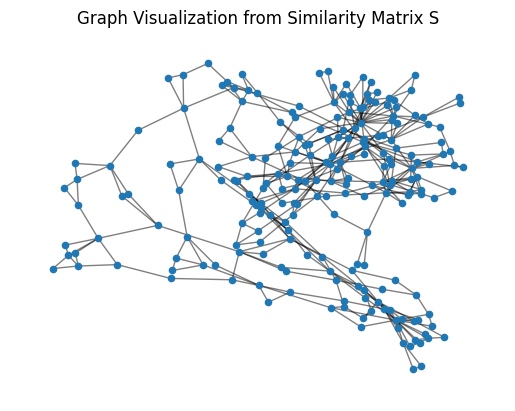

In [ ]:
k = 5 # Number of nearest neighbors
S = np.zeros((n,n))
for i in range(n):
    neighbors = np.argsort(dis[i])[1:k+1]  # Skip index 0 (self)
    for j in neighbors:
        S[i][j] = np.exp(-dis[i][j]**2 / (2 * np.median(dis[i])**2))
print(S)
G = nx.from_numpy_array(S)
pos = nx.spring_layout(G)  
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Graph Visualization from Similarity Matrix S")
plt.axis('off')
plt.show()

Create Laplacian matrix and observe it

In [124]:
D = np.diag(np.sum(S, axis=1))
print(D)
L = D - S
eigenvalues, eigenvectors = np.linalg.eig(L)
U= eigenvectors[:, np.argsort(eigenvalues)[:k]]  # Get the first k eigenvectors
norm = np.linalg.norm(U, axis=1, keepdims=True)
norm[norm == 0] = 1  # Avoid division by zero
U = U / norm

[[1.41351335 0.         0.         ... 0.         0.         0.        ]
 [0.         1.3568508  0.         ... 0.         0.         0.        ]
 [0.         0.         1.33245219 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.4901277  0.         0.        ]
 [0.         0.         0.         ... 0.         1.54995751 0.        ]
 [0.         0.         0.         ... 0.         0.         1.50143733]]


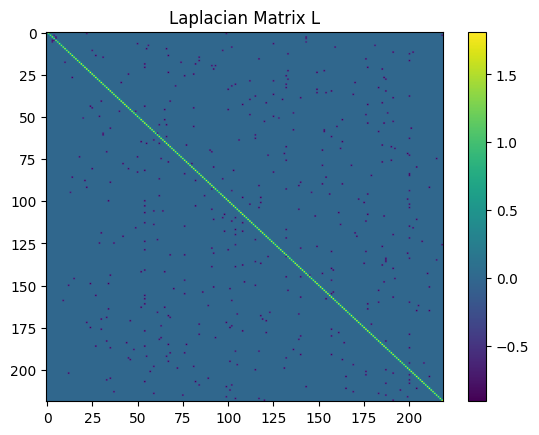

In [125]:
plt.figure()
plt.imshow(L, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Laplacian Matrix L")
plt.show()

Visualize Eigenvalues

c:\Users\Benny\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Benny\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


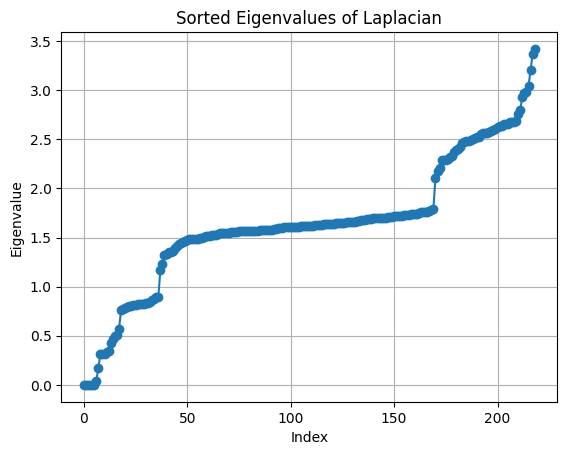

In [126]:
plt.figure()
plt.plot(np.sort(eigenvalues), marker='o')
plt.title("Sorted Eigenvalues of Laplacian")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

Do K-means to set lables

In [127]:
max_iters=100
tol=1e-5
n_samples, n_features = U.shape
K=2 # Number of clusters(for k means)
random_idxs = np.random.choice(n_samples, K, replace=False)
centroids = U[random_idxs]

for iteration in range(max_iters):
    distances = np.linalg.norm(U[:, np.newaxis] - centroids, axis=2)  # shape: (n_samples, k)
    labels = np.argmin(distances, axis=1)  # shape: (n_samples,)
    new_centroids = np.array([U[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(K)])
    if np.linalg.norm(new_centroids - centroids) < tol:break
    centroids = new_centroids

Show result

c:\Users\Benny\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
C:\Users\Benny\AppData\Local\Temp\ipykernel_366484\551480795.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


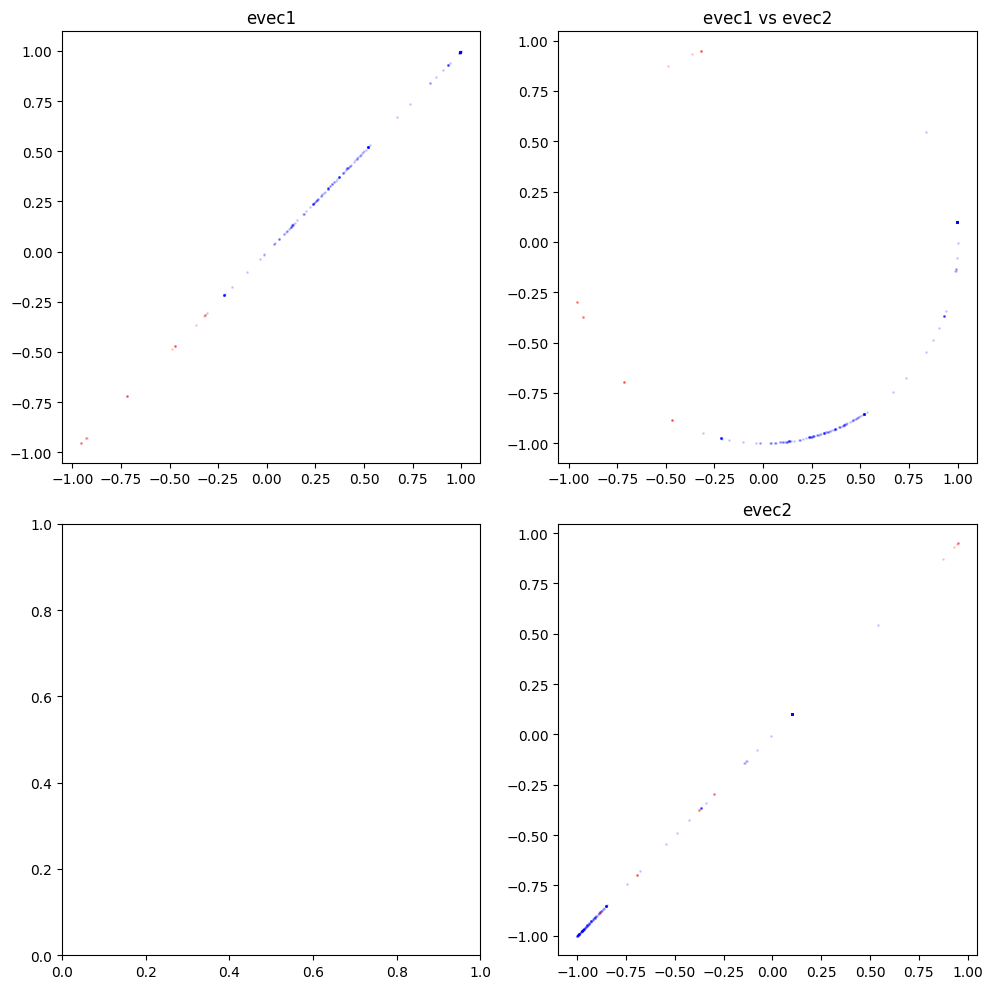

In [128]:
fig, axs = plt.subplots(k, k, figsize=(10, 10), constrained_layout=True)
for p in range(k):
    for q in range(k):
        if p == q:
            axs[p, q].set_title(f'evec{p+1}')
        if p < q:
            axs[p, q].set_title(f'evec{p+1} vs evec{q+1}')
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(n):
    for p in range(k):
        for q in range(k):
            if p <= q:
                axs[p, q].scatter(U[i, p], U[i, q], c=colors[labels[i]], s=1, alpha=0.15)
plt.tight_layout()
plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

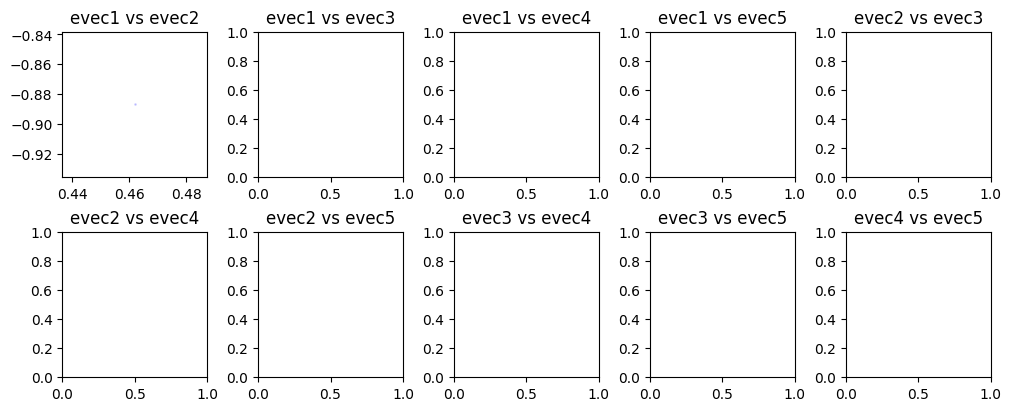

In [129]:
h, w=2,5

fig, axs = plt.subplots(h, w, figsize=(10, 4), constrained_layout=True)
vec=[[0,1],[0,2],[0,3],[0,4]
    ,[1,2],[1,3],[1,4],
    [2,3],[2,4],
    [3,4]]
for p in range(h):
    for q in range(w):
        axs[p, q].set_title(f'evec{vec[p*w+q][0]+1} vs evec{vec[p*w+q][1]+1}')

colors = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(n):
    for p in range(h):
        for q in range(w):
            axs[p, q].scatter(U[i, vec[p*w+q][0]], U[i,  vec[p*w+q][1]], c=colors[labels[i]], s=1, alpha=0.15)
plt.tight_layout()
plt.show()

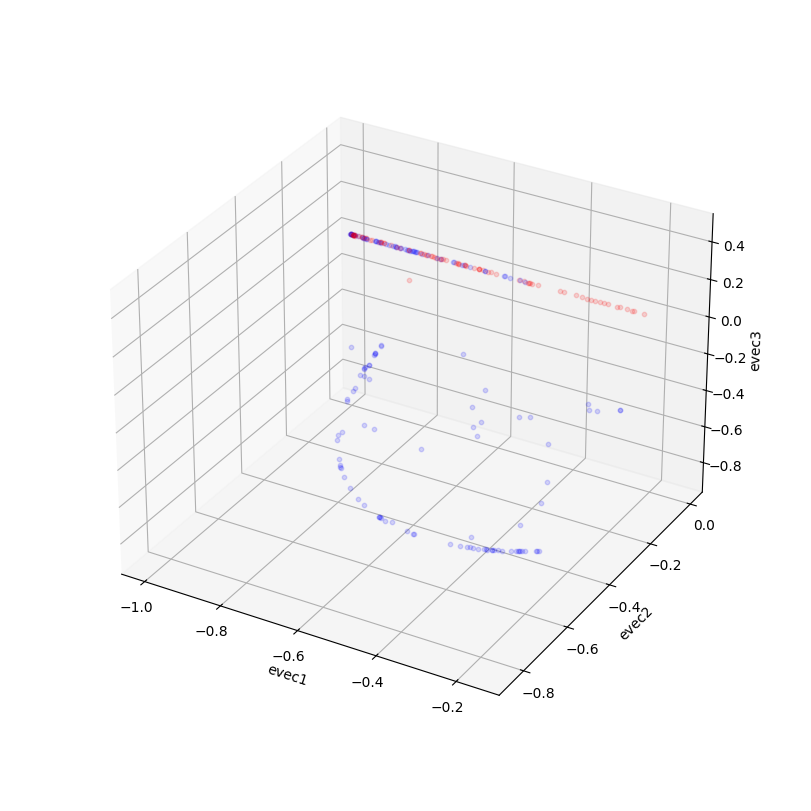

In [ ]:
fig = plt.figure(figsize=(10, 8),constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
U=U.real
for i in range(n):
    ax.scatter(U[i, 0], U[i, 1], U[i, 2], color=colors[labels[i]], s=10,alpha=0.15)
ax.set_xlabel("evec1")
ax.set_ylabel("evec2")
ax.set_zlabel("evec3")
ax.set_box_aspect(None, zoom=0.85)
plt.show()    

In [ ]:
labels_str = ["unknown "+str(label) for label in labels]
labels_str = pd.DataFrame(labels_str, columns=['Class'])
labels_str['id'] = X_ids
labels_str = labels_str[['id', 'Class']]
labels_str.to_csv(rf'D:\Github\Data_Mining_113-2\Data_Mining_Final\clustering\result\{classification}-Spectral_clustering_result.csv', index=False)